# <font  color = "#0093AF"> DIPSHIFT

In [104]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub/')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [13]:
%matplotlib notebook

In [79]:
vr=3000    #MAS frequency
v1=65000  #1H Decoupling field strength (Homonuclear)
v1het0=90000  #1H heteronuclear decoupling
N=17       #Number of time points in rotor period

phi=70*np.pi/180
S=-1/2+3/2*np.cos(phi)**2
print(f'S = {S:.3f}')

S = -0.325


In [80]:
# Some calculated parameters
magic=np.arccos(np.sqrt(1/3)) # Magic angle (for fslg)

tetra=magic*2 #Tetrahedral angle
distCC=.109  #nm
dHC=sl.Tools.dipole_coupling(distCC,'1H','13C')
print(f'delta(H-C)*S : {dHC*S/1e3:.2f} / kHz')  #This is the anisotropy, whereas one often reports half this value

distHH=distCC*np.sqrt(2-2*np.cos(tetra)) # Law of cosines (isosceles triangle)
dHH=sl.Tools.dipole_coupling(distHH,'1H','1H')
print(f'delta(H–H) : {dHH/1e3:.2f} / kHz')

delta(H-C)*S : -15.14 / kHz
delta(H–H) : 42.60 / kHz


In [81]:
# Set up experimental system, create Liouvillian
ex0=sl.ExpSys(600,Nucs=['13C','1H'],vr=vr,pwdavg=sl.PowderAvg(q=2),n_gamma=30)
ex0.set_inter('dipole',delta=dHC,i0=0,i1=1)
ex0.set_inter('CSA',delta=20,i=0,euler=[0,tetra,-np.pi/3])
ex0.set_inter('CSA',delta=4,i=1)

ex,kex=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=70*np.pi/180)

L=sl.Liouvillian(ex,kex=kex)

In [82]:
(-1/2+3/2*np.cos(-np.pi/3)**2)*dHC

-5832.04743567051

In [92]:
# Build decoupling sequences
voff=v1/np.tan(magic) #fslg offset
veff=v1/np.sin(magic) #fslg effective field
tau=1/veff   #fslg pulse length

#Spinal
Q=[10,-10,15,-15,20,-20,15,-15]
Qb=[-10,10,-15,15,-20,20,-15,15]
phase=np.concatenate((Q,Qb,Qb,Q,Qb,Q,Q,Qb))*np.pi/180

dt=1/v1het0*165/360 #165 degree pulse

t=dt*np.arange(len(phase)+1)

dec=L.Sequence(cyclic=True)
dec.add_channel('1H',t=t,v1=v1het,phase=phase,voff=0)
dec=L.Sequence().add_channel('1H',v1=v1het)

fslg=L.Sequence(cyclic=True)
_=fslg.add_channel('1H',t=[0,tau,2*tau],v1=v1,phase=[0,np.pi],voff=[voff,-voff])

<IPython.core.display.Javascript object>


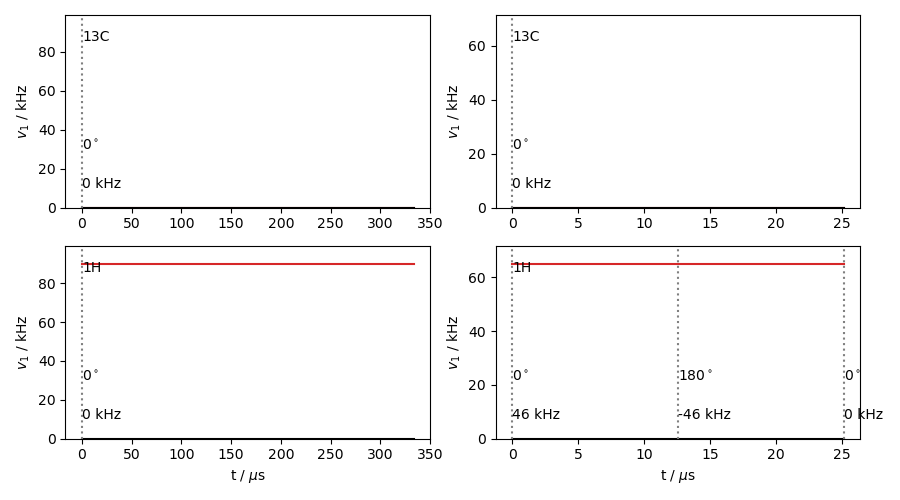

In [93]:
fig,ax=plt.subplots(2,2)
dec.plot(ax=ax.T[0])
fslg.plot(ax=ax.T[1])
fig.set_size_inches([9,5])
fig.tight_layout()

In [94]:
L.reset_prop_time()

step=L.taur/(N-1)
Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] #Propagators for N steps through two rotor periods
Uref=L.Udelta('13C')

L.reset_prop_time()
# Ufslg=[fslg.U(Dt=L.taur/(N-1),t0_seq=L.taur/(N-1)*k) for k in range(N-1)] #Propagators for N steps through rotor period
Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N steps through rotor period

In [95]:
Uref=L.Udelta('13C',np.pi)
for m in range(N-1,2*(N-1)):
    Uref=Udec[m]*Uref

In [101]:
# Run the sequence
rho=sl.Rho('13Cx','13Cx')
L.reset_prop_time()
for k in range(N):
    rho.reset()
    U=L.Ueye()
    for m in range(k):  # k steps of homonuclear decoupling
        U=Ufslg[m]*U
    
    for m in range(k,N-1):  # N-k steps of heteronuclear decoupling
        U=Udec[m]*U
    (Uref*U*rho)() #Propagate rho by U and refocus

<IPython.core.display.Javascript object>


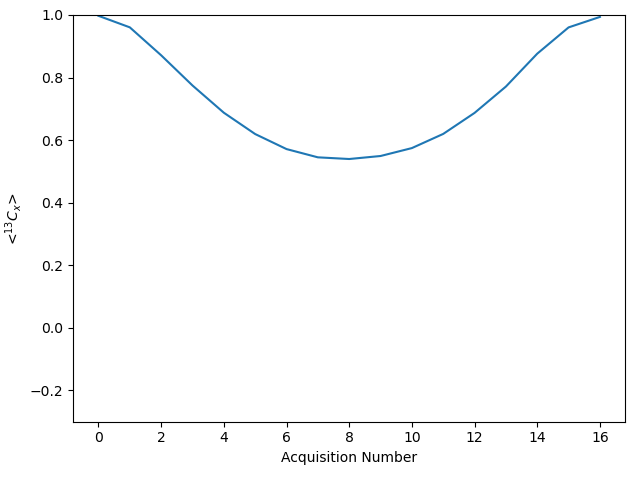

(-0.3, 1.0)

In [103]:
ax=rho.plot()
ax.figure.tight_layout()
ax.set_ylim([-.3,1])

## DIPSHIFT as a function of correlation time

Some caution should be taken when reusing objects. The Liouvillian for the sequences generated from L is L itself, so the edited kex will automatically be relayed to the sequences. However, the propagators are already calculated and will not be re-calculated when kex is changed.

A second point of caution: L caches propagators for different steps in the rotor period. Setting kex will clear this cache, but if reduced sequences are generated from L, then the edit to kex will not clear the cache of the reduced sequences. In this case, it is best just to regenerate the sequences (a savvy user could in principle clear the cache: `seq.L.clear_cache()`, or deactivate it entirely: `sl.Defaults['cache']=False`).

If you know the propagators need to be recalculated, there's not much computational time loss in reconstructing the sequence, it's just less pretty in the code, but may be better to be safe.

In [111]:
rho=[]
t0=time()
tc0=np.logspace(-9,-1,9)
for tc in tc0:
    L.kex=sl.Tools.nSite_sym(n=3,tc=tc)
    L.reset_prop_time()

    Udec=[dec.U(t0_seq=step*k,Dt=step) for k in range(2*(N-1))] #Propagators for N steps through two rotor periods
    Uref=L.Udelta('13C')

    L.reset_prop_time()
    # Ufslg=[fslg.U(Dt=L.taur/(N-1),t0_seq=L.taur/(N-1)*k) for k in range(N-1)] #Propagators for N steps through rotor period
    Ufslg=[fslg.U(Dt=L.taur/(N-1)) for k in range(N-1)] #Propagators for N steps through rotor period
    
    Uref=L.Udelta('13C',np.pi)
    for m in range(N-1,2*(N-1)):
        Uref=Udec[m]*Uref
        
    # Run the sequence
    rho.append(sl.Rho('13Cx','13Cx'))
    L.reset_prop_time()
    for k in range(N):
        rho[-1].reset()
        U=L.Ueye()
        for m in range(k):  # k steps of homonuclear decoupling
            U=Ufslg[m]*U

        for m in range(k,N-1):  # N-k steps of heteronuclear decoupling
            U=Udec[m]*U
        (Uref*U*rho[-1])() #Propagate rho by U and refocus
        
    print(f'log10(tc/s) = {np.log10(tc):.0f}, {time()-t0} seconds elapsed')

log10(tc/s) = -9, 10.730681896209717 seconds elapsed
log10(tc/s) = -8, 21.475719928741455 seconds elapsed
log10(tc/s) = -7, 32.60779285430908 seconds elapsed
log10(tc/s) = -6, 44.129148960113525 seconds elapsed
log10(tc/s) = -5, 54.68758678436279 seconds elapsed
log10(tc/s) = -4, 64.82357573509216 seconds elapsed
log10(tc/s) = -3, 75.4946539402008 seconds elapsed
log10(tc/s) = -2, 87.35669875144958 seconds elapsed
log10(tc/s) = -1, 98.20192265510559 seconds elapsed


<IPython.core.display.Javascript object>


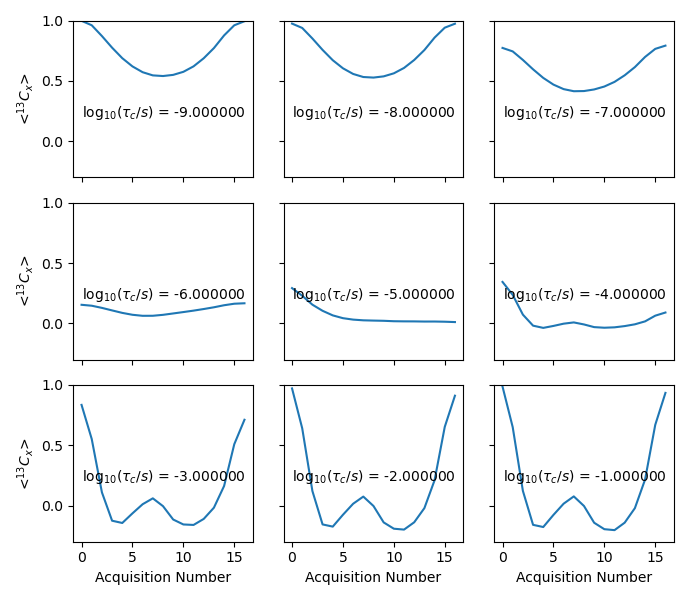

In [116]:
fig,ax=plt.subplots(3,3)
for a,rho0,tc in zip(ax.flatten(),rho,tc0):
    rho0.plot(ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
        a.set_yticklabels([])
    if not(a.is_last_row()):
        a.set_xlabel('')
        a.set_xticklabels([])
    a.text(0,.2,fr'$\log_{{10}}(\tau_c / s)$ = {np.log10(tc):.0f}')
    a.set_ylim([-.3,1])
    
fig.set_size_inches([7,6])
fig.tight_layout()